In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv('/kaggle/input/diabetic-retinopathy-2015-data-colored-resized/trainLabels.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['level'].map(diagnosis_dict_binary.get)
df['type'] = df['level'].map(diagnosis_dict.get)
df.head()

,image,level,binary_type,type
0,10_left,0,No_DR,No_DR
1,10_right,0,No_DR,No_DR
2,13_left,0,No_DR,No_DR
3,13_right,0,No_DR,No_DR
4,15_left,1,DR,Mild


<AxesSubplot:>

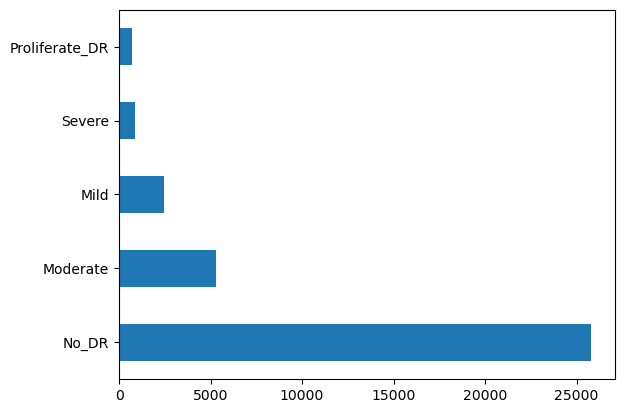

In [3]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

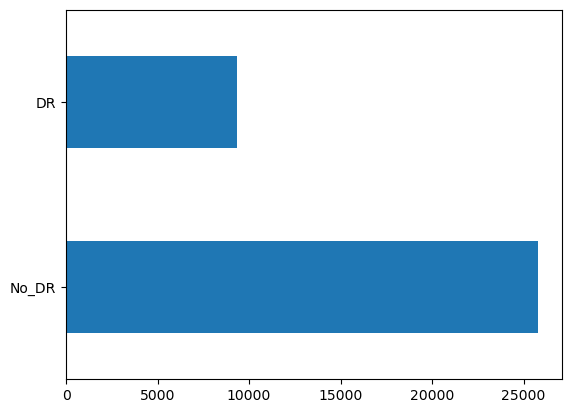

In [4]:
df['binary_type'].value_counts().plot(kind='barh')

In [5]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             18067
Moderate           3704
Mild               1710
Severe              611
Proliferate_DR      496
Name: type, dtype: int64 

No_DR             3871
Moderate           794
Mild               367
Severe             131
Proliferate_DR     106
Name: type, dtype: int64 

No_DR             3872
Moderate           794
Mild               366
Severe             131
Proliferate_DR     106
Name: type, dtype: int64 



In [6]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [7]:
# Copy images to respective working directory
src_dir = '/kaggle/input/diabetic-retinopathy-2015-data-colored-resized/colored_images/colored_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [8]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 24588 images belonging to 2 classes.
Found 5269 images belonging to 2 classes.
Found 5269 images belonging to 2 classes.


In [9]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
      
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=100,
                    validation_data=val_batches)

Epoch 1/100
769/769 [==============================] - 99s 112ms/step - loss: 0.6206 - acc: 0.7337 - val_loss: 0.5864 - val_acc: 0.7349
Epoch 2/100
769/769 [==============================] - 88s 115ms/step - loss: 0.5783 - acc: 0.7348 - val_loss: 0.5652 - val_acc: 0.7349
Epoch 3/100
769/769 [==============================] - 86s 112ms/step - loss: 0.5717 - acc: 0.7347 - val_loss: 0.5870 - val_acc: 0.7349
Epoch 4/100
769/769 [==============================] - 92s 120ms/step - loss: 0.5755 - acc: 0.7345 - val_loss: 0.5807 - val_acc: 0.7349
Epoch 5/100
769/769 [==============================] - 84s 110ms/step - loss: 0.5692 - acc: 0.7347 - val_loss: 0.5668 - val_acc: 0.7349
Epoch 6/100
769/769 [==============================] - 88s 115ms/step - loss: 0.5686 - acc: 0.7347 - val_loss: 0.5646 - val_acc: 0.7349
Epoch 7/100
769/769 [==============================] - 88s 115ms/step - loss: 0.5669 - acc: 0.7348 - val_loss: 0.5761 - val_acc: 0.7349
Epoch 8/100
769/769 [===========================

In [10]:
model.save('64x3-CNN.model')

In [11]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


165/165 [==============================] - 14s 86ms/step - loss: 1.9551 - acc: 0.7041
Accuracy:  0.7041184306144714


In [12]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')

1/1 [==============================] - 0s 257ms/step
No DR


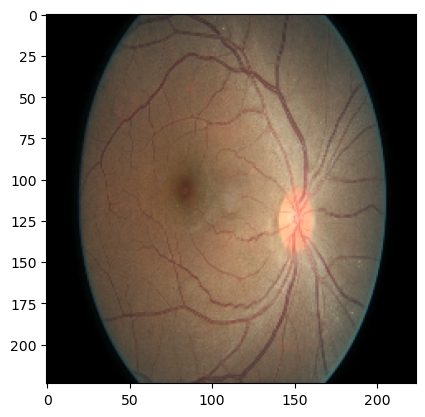

In [13]:
predict_class('../input/diabetic-retinopathy-2015-data-colored-resized/colored_images/colored_images/No_DR/10009_left.png')